# Часть 1 Расчёт метрик в SQL

### Расчёт MAU авторов
Первая задача — расчёт MAU. Здесь MAU будет определяться как количество уникальных пользователей в месяц, которые читали или слушали конкретного автора. Найдем топ-3 авторов с наибольшим MAU в ноябре и сами значения MAU.

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
 WITH november_activity AS (
    
    SELECT
        a.main_content_id,
        a.audition_id,
        a.puid,
        c.main_author_id
    FROM
    
        bookmate.audition AS a
    JOIN
    
        bookmate.content AS c ON a.main_content_id = c.main_content_id
    WHERE
    
        DATE(a.msk_business_dt_str) BETWEEN '2024-11-01'::date AND '2024-11-30'::date
)
SELECT
    
    auth.main_author_name,
    COUNT(DISTINCT na.puid) AS mau
FROM
    
    november_activity AS na
JOIN
    
    bookmate.author AS auth ON na.main_author_id = auth.main_author_id
GROUP BY
    
    auth.main_author_name
ORDER BY
    
    mau DESC
LIMIT 3;


![image.png](attachment:image.png)

### Расчёт MAU произведений
Теперь рассчитаем MAU произведений. Найдем топ-3 произведений с наибольшим MAU в ноябре, а также списки жанров этих произведений, их авторов и сами значения MAU.

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    WITH november_activity AS (
    
    SELECT
        aup.puid,
        aup.main_content_id
    
    FROM
        bookmate.audition aup
    
    WHERE
        DATE(aup.msk_business_dt_str) BETWEEN '2024-11-01' AND '2024-11-30'
)
    
SELECT
    
    c.main_content_name,
    c.published_topic_title_list,
    a.main_author_name,
    COUNT(DISTINCT na.puid) AS mau
    
FROM
    november_activity na
    
JOIN
    
    bookmate.content c ON na.main_content_id = c.main_content_id
    
JOIN
    bookmate.author a ON c.main_author_id = a.main_author_id
    
GROUP BY
    c.main_content_name,
    c.published_topic_title_list,
    a.main_author_name
    
ORDER BY mau DESC
    
LIMIT 3;


![image.png](attachment:image.png)

### Расчёт Retention Rate
Задача - проанализировать ежедневный Retention Rate всех пользователей, которые были активны 2 декабря. 
При этом неважно, новые это пользователи или нет, ведь по имеющимся данным этого всё равно не получится определить.
Рассчитаем ежедневный Retention Rate пользователей до конца представленных данных.

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
WITH users_on_dec AS (
    
    -- Пользователи, активные 2 декабря 2024
    
    SELECT 
            DISTINCT puid
    
    FROM bookmate.audition
    
    WHERE msk_business_dt_str::date = '2024-12-02'
),
    
activity_by_day AS (
    
    -- Активность этих пользователей по последующим дням
    
    SELECT
    
        a.msk_business_dt_str::date - '2024-12-02'::date AS day_since_install,
        a.puid
    
    FROM
    
        bookmate.audition a
    
    WHERE
    
        a.puid IN (SELECT puid FROM users_on_dec)
        AND a.msk_business_dt_str::date >= '2024-12-02'
)
    
SELECT
    
    day_since_install,
    COUNT(DISTINCT puid) AS retained_users,
    ROUND(
        (1.0 * COUNT(DISTINCT puid) / NULLIF(MAX(COUNT(DISTINCT puid)) OVER (), 0)),
        2
    )
    AS retention_rate
    
FROM
    activity_by_day
    
GROUP BY
    
    day_since_install
    
ORDER BY
    
    day_since_install;


### Расчёт LTV
Подписка Яндекс Плюс стоит 399 рублей в месяц. Кроме Яндекс Книг в подписку входят и другие сервисы, однако в рамках этого проекта будем считать, что пользователь приносит 399 рублей, если хотя бы раз в месяц пользуется Яндекс Книгами. При этом потенциально платящих, но неактивных пользователей не нужно учитывать.
Найдем средние LTV для пользователей в Москве и Санкт-Петербурге и сравните их между собой.
LTV = общий доход / количество пользователей. 

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
•	WITH active_sessions AS (
    
•	    SELECT
    
•	        puid,
•	        usage_geo_id,
•	        DATE_TRUNC('month', msk_business_dt_str::date) AS activity_month
    
•	    FROM
    
•	        bookmate.audition
    
•	    WHERE
    
•	        msk_business_dt_str::date BETWEEN '2024-09-01' AND '2024-12-11'
•	),
    
•	user_months AS (
    
•	    -- Определяем уникальные месяцы активности каждого пользователя
    
•	    SELECT
    
•	        puid,
•	        usage_geo_id,
•	        COUNT(DISTINCT activity_month) AS active_months
    
•	    FROM
    
•	        active_sessions
    
•	    GROUP BY
    
•	        puid,
•	        usage_geo_id
    
•	),
    
•	user_revenue AS (
    
•	    -- Расчет дохода: по 399 рублей за каждый месяц активности
    
•	    SELECT
    
•	        puid,
•	        usage_geo_id,
•	        active_months * 399 AS total_revenue
    
•	    FROM
    
•	        user_months
    
•	),
    
•	user_geo AS (
    
•	    -- Получаем название города/региона из таблицы geo
    
•	    SELECT DISTINCT
    
•	        u.puid,
•	        u.usage_geo_id,
•	        g.usage_geo_id_name
    
•	    FROM
    
•	        user_revenue u
•	    LEFT JOIN
    
•	        bookmate.geo g ON u.usage_geo_id = g.usage_geo_id
    
•	),
    
•	city_stats AS (
    
•	    -- Подсчитываем количество пользователей и сумму доходов по городам/регионам
    
•	    SELECT
    
•	        g.usage_geo_id_name AS city,
•	        COUNT(DISTINCT u.puid) AS total_users,
•	        SUM(u.total_revenue) AS total_revenue
    
•	    FROM
    
•	        user_revenue u
    
•	    LEFT JOIN
    
•	        bookmate.geo g ON u.usage_geo_id = g.usage_geo_id
    
•	    GROUP BY
    
•	        g.usage_geo_id_name
    
•	)
    
•	SELECT 
    
•	    city,
•	    total_users,
•	    ROUND(
•	        
        CASE WHEN total_users > 0 THEN total_revenue::numeric / total_users ELSE 0 END,
•	        
    
•	    ) AS ltv
    
•	FROM 
    
•	    city_stats
    
•	WHERE 
    
•	    city IN ('Санкт-Петербург', 'Москва')
    
•	ORDER BY 
•	    city;


### Расчёт средней выручки прослушанного часа — аналог среднего чека
Предполагается, что в сервисе используется модель монетизации с единой подпиской. По этой причине рассчитывать средний чек транзакций нецелесообразно, ведь он будет равен стоимости подписки. Тем не менее можно рассчитать ежемесячную среднюю выручку от часа чтения или прослушивания по такой формуле: выручка (MAU * 399 рублей) / сумма прослушанных часов.

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    •	WITH filtered_sessions AS (
    
•	    SELECT
    
•	        DATE_TRUNC('month', CAST(msk_business_dt_str AS DATE)) AS month,
•	        puid,
•	        hours
    
•	    FROM
    
•	        bookmate.audition
    
•	    WHERE
    
•	        CAST(msk_business_dt_str AS DATE) BETWEEN '2024-09-01' AND '2024-11-30'
    
•	),
    
•	monthly_stats AS (
    
•	    SELECT
    
•	    month::date,
•	        COUNT(DISTINCT puid) AS mau,
•	        SUM(hours) AS total_hours
    
•	    FROM
    
•	        filtered_sessions
    
•	    GROUP BY
•	        month
    
•	)
    
•	SELECT
    
•	    month,
•	    mau,
•	    ROUND(total_hours, 2) AS hours,
•	    ROUND((mau * 399.0) / NULLIF(total_hours, 0), 2) AS avg_hour_rev
    
•	FROM
•	    monthly_stats
    
•	ORDER BY
•	    month;


## Подготовка данных для проведения А\В теста в Python
Отберем пользователей только из Москвы и Санкт-Петербурга, оставим данные об их активности - сумму часов.
В результат должны войти следующие поля:

•	city — город пользователя;

•	puid — идентификатор пользователя;

•	hours — общее количество часов активности (вычисляется по полю hours).


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    
SELECT
     g.usage_geo_id_name AS city,
     a.puid,
    
	    SUM(a.hours) AS hours
    
	FROM
    
        bookmate.audition a
    
	JOIN
    
	    bookmate.geo g
    
	ON
	    a.usage_geo_id = g.usage_geo_id
    
	WHERE
    
	    g.usage_geo_id_name IN ('Москва', 'Санкт-Петербург')
	GROUP BY
    
	    g.usage_geo_id_name,
	    a.puid;

# Часть 2 Проверка гипотезы в Python и составление аналитической записки

Предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. 
Загрузим данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. 

Необходимо проверить наличие дубликатов в идентификаторах пользователей, а так же сравнитьразмеры групп, их статистики и распределение.

Гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическая записка будет содержать:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.

## Цели и задачи проекта
 ЦЕЛЬ: Проанализировать различия в пользовательской активности сервиса "Яндекс Книги" в Москве и Санкт-Петербурге для дальнейшей разработки обоснованных рекомендаций по увеличению вовлеченности и продаж.

Задачи:
1. Загрузить данные, провести предоработку и  первичный анализ.
2. Проверка гипотезы:
Нулевая гипотеза 
: Средняя активность одинакова.
Альтернативная гипотеза 
: Активность в Санкт-Петербурге выше.
3. По результатам составить аналитическую записку

## Описание данных

Таблицы этого проекта содержат данные о чтении и прослушивании контента в сервисе Яндекс Книги, которые включают информацию о пользователях, платформах, времени, длительности сессий и типах контента. Данные представлены за период с 1 сентября по 11 декабря 2024 года. 

### Таблица bookmate.audition содержит данные об активности пользователей и состоит из следующих полей:

•	audition_id — уникальный идентификатор сессии чтения или прослушивания;

•	puid — идентификатор пользователя;

•	usage_platform_ru — название платформы, с помощью которой пользователь слушал контент;

•	msk_business_dt_str — дата события в формате строки (московское время);

•	app_version — версия приложения, которая использовалась для чтения или прослушивания;

•	adult_content_flg — был ли это контент для взрослых: True или False;

•	hours — длительность чтения или прослушивания в часах;

•	hours_sessions_long — продолжительность длинных сессий чтения или прослушивания в часах;

•	kids_content_flg — был ли это детский контент: True или False;

•	main_content_id — идентификатор основного контента;

•	usage_geo_id — идентификатор географического местоположения.

### Таблица bookmate.content содержит данные о контенте и состоит из следующих полей:

•	main_content_id — идентификатор основного контента;

•	main_author_id — идентификатор основного автора контента;

•	main_content_type — тип контента;

•	main_content_name— название контента;

•	main_content_duration_hours — длительность контента в часах;

•	published_topic_title_list — список жанров контента.

### Таблица bookmate.author содержит данные об авторах контента и состоит из следующих полей:

•	main_author_id — идентификатор основного автора контента;

•	main_author_name — имя основного автора контента.

### Таблица bookmate.geo содержит данные о местоположении и состоит из следующих полей:

•	usage_geo_id — идентификатор географического положения;

•	usage_geo_id_name — город или регион географического положения;

•	usage_country_name — страна географического положения.

#### Предобработанные данные: 

Был выполнен SQL-запрос, результат которого сохранен в файл yandex_knigi_data.csv. Этот файл содержит:

city — город (Москва или Санкт-Петербург);
puid — идентификатор пользователя;
hours — сумма часов активности пользователя.


# 1. Загрузка данных и знакомство с ними

In [2]:
# Загрузка библиотек
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Загрузка и обзор данных
df_books= pd.read_csv('/datasets/yandex_knigi_data.csv')
df_books.info()
df_books.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
#Проверка уникальных значений в столбце city
print(df_books['city'].unique())

['Москва' 'Санкт-Петербург']


In [5]:
# Проверка наличия пропусков
print(df_books.isnull().sum())

Unnamed: 0    0
city          0
puid          0
hours         0
dtype: int64


Нет пропусков, что хорошо.

In [6]:
# Проверка наличия дубликатов
print("Дубликаты по user_id в таблице с участниками:")
duplicates = df_books[df_books.duplicated(subset='puid', keep=False)]
print(duplicates)
print(len(duplicates))

Дубликаты по user_id в таблице с участниками:
      Unnamed: 0             city              puid      hours
35            35           Москва           2637041  10.317371
134          134           Москва           9979490  32.415573
145          145           Москва          10597984  42.931506
150          150           Москва          10815097   9.086655
187          187           Москва          13626259  21.104167
...          ...              ...               ...        ...
8771        8771  Санкт-Петербург  1130000018516717   0.517778
8772        8772  Санкт-Петербург  1130000018954257  33.583294
8773        8773  Санкт-Петербург  1130000020425037   2.386944
8775        8775  Санкт-Петербург  1130000023864516  14.384722
8779        8779  Санкт-Петербург  1130000028554332   4.107774

[488 rows x 4 columns]
488


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
Некоторые пользователи присутствуют в данных сразу в 2-х городах. Выборки должны быть независимыми пользователей необходимо удалить

In [18]:
# Подсчёт количества вхождений каждого puid
puid_counts = df_books['puid'].value_counts()

# Определить puid, которые встречаются более одного раза
duplicated_puids = puid_counts[puid_counts > 1].index
print(len(duplicated_puids))

244


In [21]:
# Удалить строки с `puid`, которые встречаются более одного раза
df_books = df_books[~df_books['puid'].isin(duplicated_puids)]
print(f"Осталось строк: {len(df_books)}")

Осталось строк: 8296


In [22]:
# Анализ распределения по городам
print(df_books['city'].value_counts())

Москва             5990
Санкт-Петербург    2306
Name: city, dtype: int64


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
Неравномерное распределение пользователей. Из Москвы сильно больше.

In [30]:
# Средняя активность по городам
mean_hours = df_books.groupby('city')['hours'].mean()
print(mean_hours)

city
Москва             10.848192
Санкт-Петербург    11.264433
Name: hours, dtype: float64


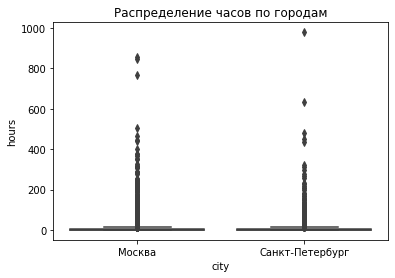

In [24]:
sns.boxplot(x='city', y='hours', data=df_books)
plt.title('Распределение часов по городам')
plt.show()

In [25]:
# Получить статистические показатели по столбцу 'hours'
print(df_books['hours'].describe())

count    8296.000000
mean       10.963892
std        37.753906
min         0.000022
25%         0.057493
50%         0.884214
75%         5.944675
max       978.764775
Name: hours, dtype: float64


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
На основе полученных статистических данных по столбцу 'hours' можно сделать следующие выводы:
- Среднее значение: в среднем пользователи проводят около 10.96 часов активности.
- Стандартное отклонение очень большое, что указывает на значительную разбросанность данных и наличие экстремальных значений.
- Минимальное значение: практически равно нулю (0.000022 часа), что говорит о пользователях с очень коротким или отсутствующим временем активности.

- Квартильные значения:
 - 25-й перцентиль ~3.4 минуты, то есть треть пользователей активны очень мало.
 - 50-й перцентиль ~53 минуты, половина пользователей активны менее часа.
 - 75-й перцентиль около 5.94 часов, то есть большинство пользователей проводят менее 6 часов.

- Максимальное значение — около 979 часов (~41 день непрерывной активности), что может указывать на наличие выбросов или аномальных данных.

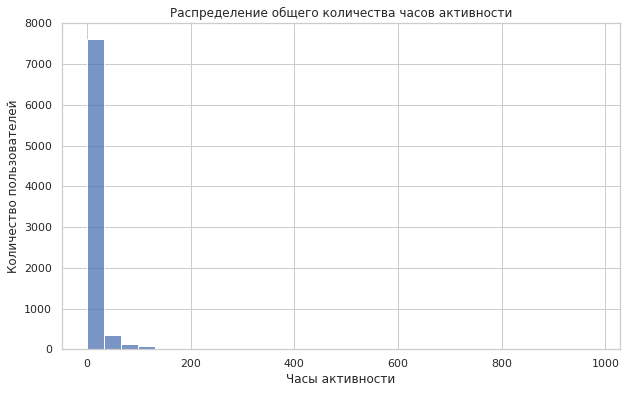

In [26]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.histplot(df_books['hours'], bins=30)
plt.title('Распределение общего количества часов активности')
plt.xlabel('Часы активности')
plt.ylabel('Количество пользователей')
plt.show()

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
Распределение времени активности у пользователей сильно скошено вправо: большинство проводят мало времени (менее часа), но есть небольшое количество пользователей с очень высоким временем активности, что значительно увеличивает среднее значение и стандартное отклонение. 

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [27]:
# Формирование выборок
moscow_hours = df_books[df_books['city'] == 'Москва']['hours']
spb_hours = df_books[df_books['city'] == 'Санкт-Петербург']['hours']

In [28]:
from scipy.stats import mannwhitneyu

In [29]:
stat, p_value = mannwhitneyu(spb_hours, moscow_hours, alternative='greater')
alpha= 0.05
# Выводим p-value и интерпретируем результат
print(f'P-value: {p_value:.4f}')
if p_value < 0.05:
    print('P-value < 0.05: Есть значитпльные различия в количестве уникальных дневных сессий между группами')
    print('Возможно есть проблема в распределении пользователей и\или сессий')
else:
    print('P-value >= 0.05: Нет значимых различий в количестве уникальных дневных сессий между группами')
    print('Группы сопоставимы по количеству сессий, тест проведен корректно')

P-value: 0.4532
P-value >= 0.05: Нет значимых различий в количестве уникальных дневных сессий между группами
Группы сопоставимы по количеству сессий, тест проведен корректно


## 3. Аналитическая записка
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:
Сравнение активности пользователей Яндекс Книги в Москве и Санкт-Петербурге:

Общее количество записей — 8296
В  Москве 5990
В Санкт-Петербурге    2306

Среднее время чтения в Москве составляет 10.9 часов, а в Санкт-Петербурге — 11.3 часов, разнича небольшая.
- Выбранный тип t-теста и уровень статистической значимости.

Для проверки гипотезы о том, что активность в Санкт-Петербурге выше, был применен непараметрический тест Манна-Уитни.
Он подходит по причине неравномерности данных.
- Результат теста, или p-value.

При уровне значимости α=0.05
P-value: 0.4532
P-value >= 0.05
- Вывод на основе полученного p-value, то есть интерпретацию результатов.

P-value >= 0.05: Нет значимых различий в количестве уникальных дневных сессий между группами
Группы сопоставимы по количеству сессий, тест проведен корректно
- Одну или две возможные причины, объясняющие полученные результаты.
